# Proyecto del Día 14 - Gestión Segura de Datos de Clientes

Este notebook implementa un sistema básico de gestión y análisis de datos de clientes, aplicando técnicas de pseudonimización, anonimización y balanceo de datos.


## Objetivo
El proyecto consiste en desarrollar un sistema de gestión y análisis de datos de clientes que implemente técnicas de pseudonimización, anonimización y balanceo de datos para proteger la privacidad de los usuarios y asegurar un análisis equitativo.


## Consignas del Proyecto
1. Cargar los datos de clientes provistos en un archivo CSV.
2. Aplicar técnicas de anonimización al campo `direccion`, `edad` y `salario` para proteger la identidad de los clientes.
3. Aplicar técnicas de pseudonimización al campo `nombre`.
4. Implementar una función de balanceo de datos para asegurar la representación equitativa de diversas categorías en el análisis posterior.
5. Realizar un análisis simple de los datos para identificar tendencias o patrones que podrían ser útiles para decisiones de negocios o marketing.


Este proyecto te permitirá aplicar prácticas esenciales de privacidad de datos y técnicas de manipulación de datos en un entorno práctico, preparándote para desafíos similares en entornos profesionales.

¡Mucha suerte y que te diviertas!

In [1]:
import os
import uuid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from dotenv import load_dotenv

In [2]:
env_path: str = '.env'
if not load_dotenv(env_path):
    raise FileNotFoundError(f'No se ha encontrado el archivo {env_path}')
else:
    load_dotenv(env_path)

### 1. Cargar los datos de clientes provistos en un archivo CSV.

In [22]:
try:
    env_key: str = 'PROJECT_DATA'
    df: pd.DataFrame = pd.read_csv(os.environ[env_key])
except:
    print(
        f'La clave {env_key} no existe en el archivo {env_path}, '
        'o su valor es incorrecto.'
    )

### 2. Aplicar técnicas de anonimización al campo `direccion`, `edad` y `salario` para proteger la identidad de los clientes.

In [23]:
# Anonimizar el campo dirección por simple supresión
# (asumiendo que no es relevante para el estudio)
df.drop(['direccion'], axis=1, inplace=True)

In [24]:
# Anonimizar el campo edad, transformandolo en un campo categórico
# Las edades pasan a ser rangos etáreos de base 10 (e.g. 20-29)
# mediante truncado
df['rango etareo'] = ''
decades: pd.Series = (df['edad'] // 10) * 10
for i, decade in enumerate(decades):
    df.loc[i, 'rango etareo'] = f'{decade} - {decade + 9}'
df.drop(['edad'], axis=1, inplace=True)

In [25]:
# Anonimizar el campo salario con ruido aleatorio
noise: np.ndarray = np.random.normal(0, 10000, size=df['salario'].shape)
df['salario'] += noise

### 3. Aplicar técnicas de pseudonimización al campo `nombre`.

In [26]:
# Pseudonomización de los valores del campo nombre
# usando un identificador único universal (UUID) para cada valor
uuid_container: list[str] = []

for _ in range(len(df)):
    uuid_container.append(str(uuid.uuid4()))

df['uuid'] = uuid_container
df.drop(['nombre'], axis=1, inplace=True)

A partir de aquí, ya parece seguro mostrar algo de `df` para los siguientes pasos. 😁

In [27]:
df.head()

,categoria,salario,rango etareo,uuid
0,0,73659.764942,60 - 69,aafefa13-2923-4345-aea5-8abe4a79c42e
1,1,43291.981685,60 - 69,1a425dae-a514-4a1f-8256-4b1b9c698d4e
2,0,58721.960620,10 - 19,fb4e6ed0-ef28-4fa0-95a3-538d25619dc2
3,1,17776.307702,20 - 29,cc3ed20a-0557-4e05-846c-e0a3706ce1b0
4,1,26248.709763,20 - 29,0fc5d83c-1838-4573-ad7d-1a8e21f6dca5


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   categoria     200 non-null    int64  
 1   salario       200 non-null    float64
 2   rango etareo  200 non-null    object 
 3   uuid          200 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.4+ KB


In [29]:
df.describe()

,categoria,salario
count,200.000000,200.000000
mean,0.570000,48759.916212
std,0.496318,15598.551538
min,0.000000,9986.180656
25%,0.000000,39436.152716
50%,1.000000,50697.430551
75%,1.000000,59081.731269
max,1.000000,86834.899123


### 4. Implementar una función de balanceo de datos para asegurar la representación equitativa de diversas categorías en el análisis posterior.

Preliminarmente, los datos estadísticos de `df.describe()` parecen indicar que:

- Existen sólo dos categorías: `0` y `1`

- Hay más instancias para la segunda categoría que para la primera, tomando como referencia la media de `0.57`

No obstante, en honor a la rigurosidad, conviene verificar estos puntos antes de proceder con el objetivo de este paso.

In [30]:
categories: list[int] = df['categoria'].unique().tolist()
categories

[0, 1]

Dado que el uso de números crudos (sin contexto) en variables categóricas es un poco "vago" (y que, dicho sea de paso, puede confundirse con variables realmente numéricas, como `salario`), me he tomado la licencia de darle unos nombres de fantasía más interesantes para el contexto de análisis. 😁

In [31]:
motes: list[str] = ['Arenisca', 'Basalto']
df['categoría'] = ''
for i, categoria in enumerate(df['categoria']):   # sin tilde
    df.loc[i, 'categoría'] = motes[0] if categoria == 0 else motes[1]
df.drop(['categoria'], axis=1, inplace=True)

Efectivamente, existen sólo dos categorías: `0` y `1`. Veamos la proporción exacta de ellas en el conjunto `df`:

In [59]:
category_0: int = (df['categoría'] == motes[0]).sum()
category_1: int = (df['categoría'] == motes[1]).sum()

print(f'Instancias de categoría {motes[0].upper()}: {category_0}')
print(f'Instancias de categoría {motes[1].upper()}: {category_1}')

Instancias de categoría ARENISCA: 86
Instancias de categoría BASALTO: 114


Efectivamente, se verifica que hay un desbalance en la repartición de instancias entre categorías en el conjunto de datos.

Por lo tanto, procederemos con las operaciones para asegurar la representación equitativa de ambas categorías.

In [58]:
grouped_df = df.groupby('categoría')

balanced_data: pd.DataFrame = pd.DataFrame()

for name, group in grouped_df:
    balanced_group = resample(
        group,
        replace=True,
        n_samples=114,
        random_state=123
    )
    balanced_data = pd.concat([balanced_data, balanced_group])

category_0: int = (balanced_data['categoría'] == motes[0]).sum()
category_1: int = (balanced_data['categoría'] == motes[1]).sum()

print(f'Instancias de categoría {motes[0].upper()}: {category_0}')
print(f'Instancias de categoría {motes[1].upper()}: {category_1}')

Instancias de categoría ARENISCA: 114
Instancias de categoría BASALTO: 114


Las instancias de ambas categorías se han igualado exitosamente. Veamos las características de `balanced_data`:

In [18]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 192 to 160
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   salario       228 non-null    float64
 1   rango etareo  228 non-null    object 
 2   uuid          228 non-null    object 
 3   categoría     228 non-null    object 
dtypes: float64(1), object(3)
memory usage: 8.9+ KB


### 5. Realizar un análisis simple de los datos para identificar tendencias o patrones que podrían ser útiles para decisiones de negocios o marketing.

Veamos algunos datos estadísticos descriptivos del nuevo conjunto balanceado:

In [66]:
balanced_data_stats: pd.DataFrame = balanced_data.describe().round()
balanced_data_stats

,salario
count,228.0
mean,48429.0
std,15917.0
min,9986.0
25%,39007.0
50%,50907.0
75%,59082.0
max,86835.0


In [46]:
# Separar el dataframe balanceado por categoría
data_categoria_0 = balanced_data[balanced_data['categoría'] == motes[0]]
data_categoria_1 = balanced_data[balanced_data['categoría'] == motes[1]]

In [67]:
# Ver estadísticas de salario para la primera categoría
stats_cat_0 = data_categoria_0.describe().round()
stats_cat_0

,salario
count,114.0
mean,50430.0
std,15463.0
min,9986.0
25%,41486.0
50%,51117.0
75%,61045.0
max,86348.0


In [69]:
# Ver estadísticas de salario para la segunda categoría
stats_cat_1 = data_categoria_1.describe().round()
stats_cat_1

,salario
count,114.0
mean,46427.0
std,16179.0
min,12613.0
25%,36274.0
50%,49609.0
75%,57736.0
max,86835.0


#### Relación entre categoría y salario.

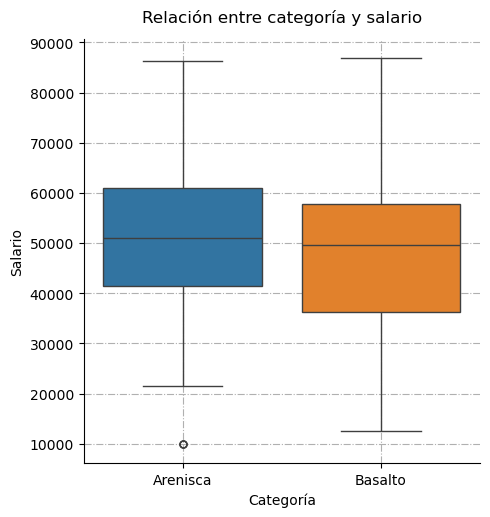

In [34]:
categoria_salario: sns.FacetGrid = sns.catplot(
    data=balanced_data,
    x='categoría',
    y='salario',
    kind='box',
    hue='categoría'
)
categoria_salario.set_axis_labels('Categoría', 'Salario')
plt.title('Relación entre categoría y salario', pad=12)
plt.grid(True, linestyle='-.')
plt.show()

La distribución de salarios en ambas categorías, `Arenisca` y `Basalto`, es similarmente amplia. No obstante, se aprecian diferencias entre los rangos intercuartílicos (IQR) de ambas. Teniendo en cuenta que el IQR general es de entre `$39,007` y `$59,082`, con la **mediana general** en `$50,907`, se observa que:

- el IQR de los clientes de la categoría `Arenisca` poseen **salarios ligeramente superiores**, de entre `$41,486` y `$61,045`, con la mediana de la categoría en `$51,117`.

- mientras que el IQR de los clientes de la categoría `Basalto` poseen **salarios ligeramente inferiores**, de entre `$36,274` y `$57,736`, con la mediana de la categoría en `$49,609`.

Por otro lado, cabe destacar que, al menos, un cliente de la categoría `Arenisca` tiene un salario inusualmente bajo, llegando a un mínimo de `$9,986` (véase el _outlier_ en el gráfico). Según el gráfico, el salario mínimo esperado para `Arenisca` está sobre los `$20.000`. Esta ocurrencia no se observa en la categoría `Basalto`, donde no se aprecian _outliers_, y el salario mínimo llega normalmente hasta los `$12,613`

En definitiva, los clientes de la categoría `Arenisca` presentan un rango salarial ligeramente más alto y concentrado alrededor de valores medianos-altos, pero también muestra una mayor variabilidad en los salarios bajos (reflejado por el _outlier_ bajo los bigotes). `Basalto`, por otro lado, tiene salarios que se concentran más hacia el centro de su rango y presenta menor dispersión en salarios altos, lo cual podría interpretarse como una distribución salarial más estable en torno a su mediana.